In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# Set some Pandas options
pd.set_option('notebook_repr_html', False)
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 20)
#max rows and columns are important not to crash the notebook

In [7]:
all_data = pd.read_excel("..//Data/traffic-collision/Collisions.xlsx", sheet_name = 'All_Collisions_1')
all_data

       OBJECTID  Shape                              ADDRESS  \
0         28948    NaN         E CONE BLVD / N O HENRY BLVD   
1         28949    NaN             N CHURCH ST / CHARLES ST   
2         28950    NaN  JOSEPH M BRYAN BLVD / NEW GARDEN RD   
3         28951    NaN              W MARKET ST / N TATE ST   
4         28952    NaN           PHILLIPS AV / N ENGLISH ST   
5         28953    NaN              SUMMIT AV / PHILLIPS AV   
6         28954    NaN       E BESSEMER AV / YANCEYVILLE ST   
7         28955    NaN      BATTLEGROUND AV / W BESSEMER AV   
8         28956    NaN             E BESSEMER AV / SYKES AV   
9         28957    NaN         E LINDSAY ST / E WENDOVER AV   
...         ...    ...                                  ...   
51994    100175    NaN          E GATE CITY BLVD / MACON ST   
51995    100164    NaN            E WENDOVER AV / ELWELL AV   
51996    100165    NaN                               I 40 W   
51997    100174    NaN          E WENDOVER AV / N CHURC

### Data Cleaning

In [8]:
all_data.isnull().sum()

OBJECTID                0
Shape               52004
ADDRESS                22
ACCIDENT_CAUSE         96
COLLISION_DESC          4
WEATHER                26
LIGHT_CONDITIONS       26
ROAD_CLASS             24
TRAFFIC_CONTROL        45
PEDESTRIAN_REL        900
                    ...  
X                       0
Y                       0
BIPED               50859
SEVERITY              132
SEVERITY_CD           132
A_INJURIES            132
B_INJURIES            132
C_INJURIES            132
CASE_NUM                0
DEPARTMENT          40778
Length: 27, dtype: int64

In [9]:
all_data.COLLISION_DESC.value_counts()

ANGLE                                                                                                                                                   11094
REAR END, SLOW OR STOP                                                                                                                                  10907
SIDESWIPE, SAME DIRECTION                                                                                                                                3925
Rear End, Slow Or Stop                                                                                                                                   2714
Angle                                                                                                                                                    2601
RAN OFF ROAD - RIGHT                                                                                                                                     2473
BACKING UP                                          

In [10]:
all_data.PEDESTRIAN_REL.value_counts()

NO        50003
YES        1074
N            20
<Null>        4
MO            1
-             1
no            1
Name: PEDESTRIAN_REL, dtype: int64

In [11]:
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False) == False, "PEDESTRIAN_REL"] = "NO"
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False), "PEDESTRIAN_REL"] = "YES"
all_data.PEDESTRIAN_REL.value_counts()

NO     51230
YES      774
Name: PEDESTRIAN_REL, dtype: int64

In [12]:
all_data.BIPED.value_counts()

P         921
B         210
<Null>     12
p           2
Name: BIPED, dtype: int64

In [13]:
targets = ['PEDESTRIAN', 'CYCLIST']
#all_data.loc[all_data["COLLISION_DESC"].apply(lambda sentence: any(word in sentence for word in targets)) == False, 'BIPED'] = 'N'
all_data.loc[(~all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False)) &
             (~all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False)), 'BIPED'] = 'M'
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False), 'BIPED'] = 'P'
all_data.loc[all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False), 'BIPED'] = 'B'
#all_all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False) == False, "PEDESTRIAN_REL"] = "NO"data.loc[all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False), "PE_CY_MO"] = "CY"
all_data.BIPED.value_counts()

M    51111
P      774
B      119
Name: BIPED, dtype: int64

In [9]:
all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                        29937
Daylight                         6806
DARK-LIGHTED ROADWAY             6299
DARK - LIGHTED ROADWAY           2370
Dark - Lighted Roadway           2069
DARK-ROADWAY NOT LIGHTED         1181
DUSK                             1123
DARK - ROADWAY NOT LIGHTED        494
Dark - Roadway Not Lighted        486
DAWN                              403
                                ...  
DARK ROADWAY-NOT LIGHTED            1
DARK - LIGHTED ROADWAY\r            1
DARK - LIGHTED ROADWAR              1
DARK-LIGHTED ORADWAY                1
DARK-RAODWAY NOT LIGHTED            1
DARK - ROADWAY NOT LIGHTED\r        1
DARK - LIGHTED WAY                  1
DARK - UNKNOWN LIGHTING\r           1
SNOW                                1
RAIN                                1
Name: LIGHT_CONDITIONS, Length: 42, dtype: int64

In [10]:
all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                        29937
Daylight                         6806
DARK-LIGHTED ROADWAY             6299
DARK - LIGHTED ROADWAY           2370
Dark - Lighted Roadway           2069
DARK-ROADWAY NOT LIGHTED         1181
DUSK                             1123
DARK - ROADWAY NOT LIGHTED        494
Dark - Roadway Not Lighted        486
DAWN                              403
                                ...  
DARK ROADWAY-NOT LIGHTED            1
DARK - LIGHTED ROADWAY\r            1
DARK - LIGHTED ROADWAR              1
DARK-LIGHTED ORADWAY                1
DARK-RAODWAY NOT LIGHTED            1
DARK - ROADWAY NOT LIGHTED\r        1
DARK - LIGHTED WAY                  1
DARK - UNKNOWN LIGHTING\r           1
SNOW                                1
RAIN                                1
Name: LIGHT_CONDITIONS, Length: 42, dtype: int64

In [11]:
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Daylight', 'DAYLGHT']), 'LIGHT_CONDITIONS'] = 'DAYLIGHT'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['DARK - LIGHTED ROADWAY', 'Dark - Lighted Roadway', 
                                               'DARK-LIGHTED ORADWAY', 'DARL-LIGHTED ROADWAY',
                                               'DARK - LIGHTED ROADAY', 'DARK - LIGHTED ROADWAR',
                                               'DARK - LIGHT ROADWAY', 'DARK - LIGHTED WAY',
                                               'DARK LIGHTED ROADWAY', 'DARK- LIGHTED ROADWAY']),'LIGHT_CONDITIONS'] = 'DARK-LIGHTED ROADWAY'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dark - Roadway Not Lighted', 'DARK - ROADWAY NOT LIGHTED\r', 
                                               'DARK-RAODWAY NOT LIGHTED', 'DARK-ROADWAY NOT LIGHTEDDARK - ROADWAY NOT LIGHTED\r',
                                               'DARK-ROADWAY NOT LIGHTED', 'DARK ROADWAY NOT LIGHTED']), 
            'LIGHT_CONDITIONS'] = 'DARK - ROADWAY NOT LIGHTED'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['DARK - UNKNOWN LIGHTING', 'DARK UNKNOWN LIGHTING', 
                                               'DARK - UNKNOWN LIGHTING\r', 'Dark - Unknown Lighting']), 
            'LIGHT_CONDITIONS'] = 'DARK-UNKNOWN LIGHTING'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dusk']), 'LIGHT_CONDITIONS'] = 'DUSK'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dawn']), 'LIGHT_CONDITIONS'] = 'DAWN'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Unknown']), 'LIGHT_CONDITIONS'] = 'UNKNOWN'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['OTHER*', 'Other', 'OTHER*\r']), 'LIGHT_CONDITIONS'] = 'OTHER'

all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                      36744
DARK-LIGHTED ROADWAY          10772
DARK - ROADWAY NOT LIGHTED     2171
DUSK                           1387
DAWN                            523
UNKNOWN                         194
DARK-UNKNOWN LIGHTING           154
OTHER                            23
CLOUDY                            4
SNOW                              1
SEVERE CROSSWINDS                 1
DARK - LIGHTED ROADWAY\r          1
BLOWING SAND, DIRT, SNOW          1
RAIN                              1
DARK ROADWAY-NOT LIGHTED          1
Name: LIGHT_CONDITIONS, dtype: int64

In [12]:
all_data.WEATHER.value_counts()

CLEAR                                 31066
Clear                                  6375
CLOUDY                                 6122
RAIN                                   4484
Cloudy                                 1364
Rain                                   1291
SNOW                                    484
Snow                                    197
SLEET,HAIL,FREEZING RAIN/DRIZZLE        187
SLEET, HAIL, FREEZING RAIN/DRIZZLE      160
                                      ...  
CLEAR\nCLEAR\nCLEAR\nCLEAR                1
CEAR                                      1
OTHER*\r                                  1
SLEET. HAIL. FREEZING RAIN/DRIZZLE        1
FOG, SMOG, SMOKE\r\n\r                    1
RAIN/ SNOW                                1
RAIN\r                                    1
CLOUDLY / CLEAR                           1
-                                         1
RAIN/CLOUDY\nRAIN/CLOUDY                  1
Name: WEATHER, Length: 34, dtype: int64

In [13]:
all_data.loc[all_data['WEATHER'].isin(['Clear', 'CEAR', 'CLEAR\nCLEAR\nCLEAR\nCLEAR']), 'WEATHER'] = 'CLEAR'
all_data.loc[all_data['WEATHER'].isin(['Cloudy']), 'WEATHER'] = 'CLOUDY'
all_data.loc[all_data['WEATHER'].isin(['Rain', 'RAIN\r']), 'WEATHER'] = 'RAIN'
all_data.loc[all_data['WEATHER'].isin(['Snow', 'SNOW\r']), 'WEATHER'] = 'SNOW'
all_data.loc[all_data['WEATHER'].isin(['SLEET, HAIL, FREEZING RAIN/DRIZZLE',
                                      'SLEET. HAIL. FREEZING RAIN/DRIZZLE',
                                      'Sleet, Hail, Freezing Rain/Drizzle']), 'WEATHER'] = 'SLEET,HAIL,FREEZING RAIN/DRIZZLE'
all_data.loc[all_data['WEATHER'].isin(['FOG,SMOG,SMOKE', 'Fog, Smog, Smoke'
                                       , 'FOG, SMOG, SMOKE\r\n\r']), 'WEATHER'] = 'FOG, SMOG, SMOKE'
all_data.loc[all_data['WEATHER'].isin(['BLOWING SAND,DIRT,SNOW', 'Blowing Sand, Dirt, Snow']), 'WEATHER'] = 'BLOWING SAND, DIRT, SNOW'
all_data.loc[all_data['WEATHER'].isin(['OTHER*\r', 'Other', 'OTHER*']), 'WEATHER'] = 'OTHER'
all_data.loc[all_data['WEATHER'].isin(['CLOUDY / RAIN', 'RAIN/CLOUDY\nRAIN/CLOUDY']), 'WEATHER'] = 'RAIN / CLOUDY'
all_data.loc[all_data['WEATHER'].isin(['-']), 'WEATHER'] = 'UNKNOWN'
all_data.WEATHER.value_counts()

CLEAR                               37443
CLOUDY                               7486
RAIN                                 5776
SNOW                                  683
SLEET,HAIL,FREEZING RAIN/DRIZZLE      403
FOG, SMOG, SMOKE                      117
OTHER                                  51
BLOWING SAND, DIRT, SNOW                6
RAIN / CLOUDY                           6
SEVERE CROSSWINDS                       3
RAIN/ SNOW                              1
CLOUDLY / CLEAR                         1
RAIN/ SEVERE CROSSWINDS                 1
UNKNOWN                                 1
Name: WEATHER, dtype: int64

In [14]:
all_data.TRAFFIC_CONTROL.value_counts()

NO CONTROL PRESENT                       26098
STOP AND GO SIGNAL                       10645
No Control Present                        5225
STOP SIGN                                 3760
Stop And Go Signal                        2936
Stop Sign                                 1005
---                                        553
FLASHING STOP AND GO SIGNAL                514
YIELD SIGN                                 467
Flashing Stop And Go Signal                146
                                         ...  
NO CONTROL PRSSENT                           1
NO CONTROL PRESEMT                           1
NO COLTROL PRESENT                           1
NO CNTROL PRESENT                            1
NO CONTRL PRESENT                            1
FLASHING SIGNAL WITHOUT STOP SIGN\r          1
DOUBLE YELLOW LINE, NO PASSING ZONE\r        1
NO CONROL PRESENT                            1
--                                           1
NO OCNTROL PRESENT                           1
Name: TRAFFIC

In [15]:
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Stop Sign']), 'TRAFFIC_CONTROL'] = 'STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['No Control Present', 'NO CNTROL PRESENT', 'NO OCNTROL PRESENT',
                                               'NO CONROL PRESENT', 'NO CONTRL PRESENT', 'CONTROL NOT PRESENT',
                                              'NO CONTROL PRESEMT', 'NO COLTROL PRESENT', 'NO CONTROL PRSENT',
                                              'NO CONTROL PRSSENT', 'NO CONTOL PRESENT', 'NONE']), 
             'TRAFFIC_CONTROL'] = 'NO CONTROL PRESENT'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Stop And Go Signal', 'STOP AND GO SGNAL',
                                              'STOP AND GO  SIGNAL']), 'TRAFFIC_CONTROL'] = 'STOP AND GO SIGNAL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Yield Sign']), 'TRAFFIC_CONTROL'] = 'YIELD SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Stop And Go Signal']), 
             'TRAFFIC_CONTROL'] = 'FLASHING STOP AND GO SIGNAL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Signal With Stop Sign']), 
             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITH STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Rr Flasher']), 'TRAFFIC_CONTROL'] = 'RR FLASHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['OTHER*', 'Other']), 'TRAFFIC_CONTROL'] = 'OTHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['School Zone Signs']), 'TRAFFIC_CONTROL'] = 'SCHOOL ZONE SIGNS'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Signal Without Stop Sign', 'FLASHING SIGNAL WITHOUT STOP SIGN\r']), 
             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITHOUT STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Warning Sign']), 'TRAFFIC_CONTROL'] = 'WARNING SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Human Control']), 'TRAFFIC_CONTROL'] = 'HUMAN CONTROL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['---', '--']), 'TRAFFIC_CONTROL'] = 'UNKNOWN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Rr Gate And Flasher']), 'TRAFFIC_CONTROL'] = 'RR GATE AND FLASHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Double Yellow Line, No Passing Zone', 
                                               'DOUBLE YELLOW LINE, NO PASSING ZONE\r']),
             'TRAFFIC_CONTROL'] = 'DOUBLE YELLOW LINE, NO PASSING ZONE'
#all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['STOP AND GO SIGNAL']), 'TRAFFIC_CONTROL'] = 'STOP SIGN'
#all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['FLASHING STOP AND GO SIGNAL']), 
#             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITH STOP SIGN'
all_data.TRAFFIC_CONTROL.value_counts()

NO CONTROL PRESENT                     31339
STOP AND GO SIGNAL                     13583
STOP SIGN                               4765
FLASHING STOP AND GO SIGNAL              660
YIELD SIGN                               594
UNKNOWN                                  554
OTHER                                    111
DOUBLE YELLOW LINE, NO PASSING ZONE       99
WARNING SIGN                              85
FLASHING SIGNAL WITH STOP SIGN            54
HUMAN CONTROL                             39
RR GATE AND FLASHER                       34
FLASHING SIGNAL WITHOUT STOP SIGN         25
SCHOOL ZONE SIGNS                          7
RR FLASHER                                 7
RR CROSSBUCKS ONLY                         3
Name: TRAFFIC_CONTROL, dtype: int64

In [16]:
all_data.HIT_RUN.value_counts()

NO     23087
N      13972
No      4621
Y       2221
YES     2150
Yes     1092
Name: HIT_RUN, dtype: int64

In [17]:
all_data.loc[all_data['HIT_RUN'].isin(['N', 'No']), 'HIT_RUN'] = 'NO'
all_data.loc[all_data['HIT_RUN'].isin(['Y', 'Yes']), 'HIT_RUN'] = 'NO'
all_data.HIT_RUN.value_counts()

NO     44993
YES     2150
Name: HIT_RUN, dtype: int64

In [18]:
all_data.SEVERITY.value_counts()

O No Injury                          31884
C Type Injury (Possible)             16286
B Type Injury (Evident)               2052
Unknown                                800
B Type Injury (Suspected Minor)        671
A Type Injury (Disabling)              128
A Type Injury (Suspected Serious)       49
C Type Injury (Possible)\r               1
UNKNOWN                                  1
Name: SEVERITY, dtype: int64

In [19]:
all_data.loc[all_data['SEVERITY'].isin(['C Type Injury (Possible)\r']), 'SEVERITY'] = 'C Type Injury (Possible)'
all_data.loc[all_data['SEVERITY'].isin(['Unknown']), 'SEVERITY'] = 'UNKNOWN'
all_data.SEVERITY.value_counts()

O No Injury                          31884
C Type Injury (Possible)             16287
B Type Injury (Evident)               2052
UNKNOWN                                801
B Type Injury (Suspected Minor)        671
A Type Injury (Disabling)              128
A Type Injury (Suspected Serious)       49
Name: SEVERITY, dtype: int64

In [20]:
all_data.ACCIDENT_DATE.value_counts()
#all_data['TIME'] = all_data.ACCIDENT_DATE.dt.time
#time is not available in this location for fatalities data
all_data['CASE_NUM'] = all_data.CASE_NUM.astype(str)
all_data['DATE'] = pd.to_datetime(all_data.CASE_NUM.str[:8])
all_data['YEAR'] = all_data.DATE.dt.year
all_data['MONTH'] = all_data.DATE.dt.month
all_data['DAY'] = all_data.DATE.dt.day_name()

all_data.DAY.value_counts()

Friday       8958
Wednesday    7868
Thursday     7821
Tuesday      7703
Monday       7607
Saturday     6758
Sunday       5289
Name: DAY, dtype: int64

In [21]:
ped_data = all_data[all_data.PEDESTRIAN_REL == 'YES']
noped_data = all_data[all_data.PEDESTRIAN_REL == 'NO']

In [22]:
ped_data.ACCIDENT_YEAR.value_counts()

2015    171
2014    163
2018    155
2017    145
2016    140
Name: ACCIDENT_YEAR, dtype: int64

In [23]:
noped_data.ACCIDENT_YEAR.value_counts()

2018    11102
2017    10899
2016    10718
2015     9778
2014     8733
Name: ACCIDENT_YEAR, dtype: int64

In [24]:
ped_data.SEVERITY.value_counts()

C Type Injury (Possible)             435
B Type Injury (Evident)              173
B Type Injury (Suspected Minor)       55
A Type Injury (Disabling)             42
O No Injury                           18
A Type Injury (Suspected Serious)     16
Name: SEVERITY, dtype: int64

In [25]:
noped_data.SEVERITY.value_counts()

O No Injury                          31866
C Type Injury (Possible)             15852
B Type Injury (Evident)               1879
UNKNOWN                                801
B Type Injury (Suspected Minor)        616
A Type Injury (Disabling)               86
A Type Injury (Suspected Serious)       33
Name: SEVERITY, dtype: int64

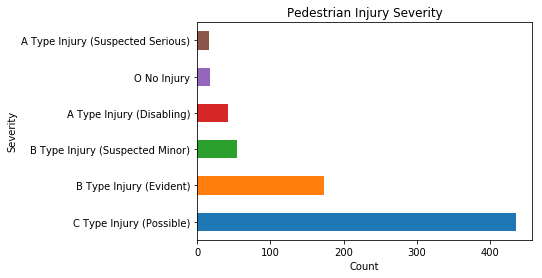

In [26]:
ped_data['SEVERITY'].value_counts().plot(kind='barh')
plt.title('Pedestrian Injury Severity')
plt.ylabel('Severity')
plt.xlabel('Count')
plt.show()

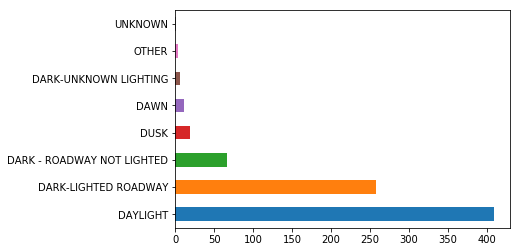

In [27]:
ped_data['LIGHT_CONDITIONS'].value_counts().plot(kind='barh')
plt.show()

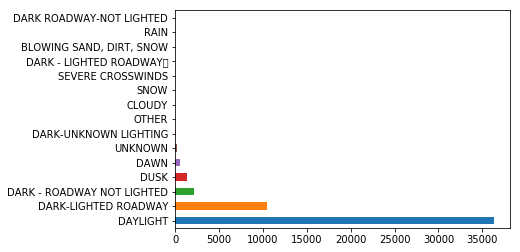

In [28]:
noped_data['LIGHT_CONDITIONS'].value_counts().plot(kind='barh')
plt.show()

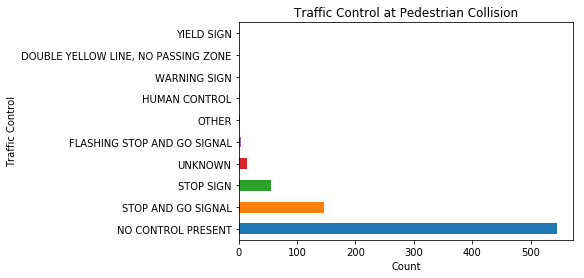

In [29]:
ped_data['TRAFFIC_CONTROL'].value_counts().plot(kind='barh')
plt.title('Traffic Control at Pedestrian Collision')
plt.ylabel('Traffic Control')
plt.xlabel('Count')
plt.show()

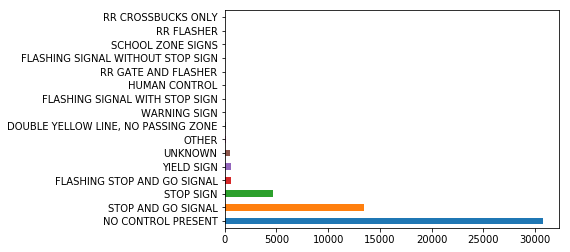

In [30]:
noped_data['TRAFFIC_CONTROL'].value_counts().plot(kind='barh')
plt.show()

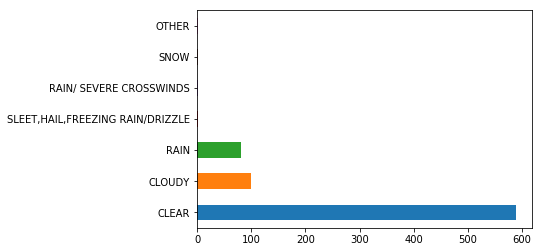

In [31]:
ped_data['WEATHER'].value_counts().plot(kind='barh')
plt.show()

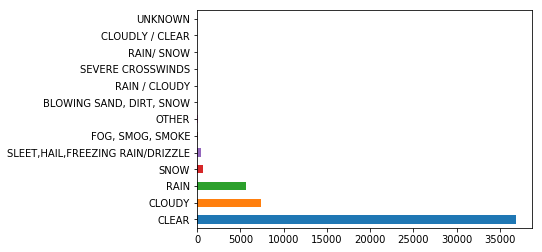

In [32]:
noped_data['WEATHER'].value_counts().plot(kind='barh')
plt.show()

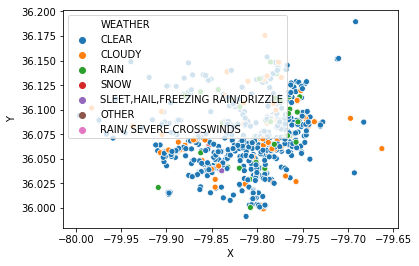

In [33]:
#sns.scatterplot(x="X", y="Y", hue="TRAFFIC_CONTROL", data=ped_data)
sns.scatterplot(x="X", y="Y", hue="WEATHER", data=ped_data)
plt.show()